## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1/BBBC020_v1-cells'
base = '/Users/nicholassofroniew/Documents/DATA/neurofinder/mean'
train_dataset = BroadDataset(base, 'train')

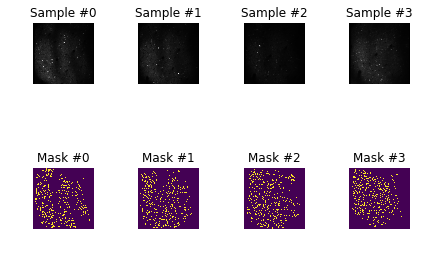

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [5]:
from numpy import asarray
tmp = asarray(img)
tmp.max()

255

## Define transforms

In [6]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip(),
#    extended_transforms.CenterCrop(512),
#    extended_transforms.RandomRotate(45),
    extended_transforms.RandomWarp(5, 20)])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [7]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform)

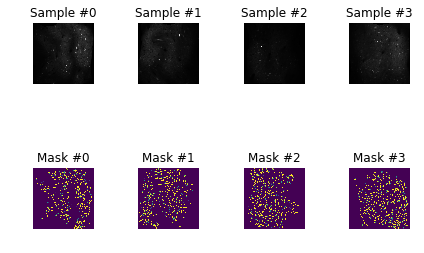

In [8]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [9]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [10]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [11]:
from segmentation.model import UNet

In [12]:
net = UNet(1)

In [13]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [14]:
from segmentation.utilities import mIoULoss, CrossEntropyLoss2d, BCELoss2d

In [15]:
from torch import nn
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()
#criterion = nn.BCEWithLogitsLoss()

In [16]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [17]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0)).squeeze(0)

In [18]:
print(tmp)
print(foo)
#print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 1x512x512]

Variable containing:
( 0 ,.,.) = 
  1.5706e+00  1.7200e+00  1.7416e+00  ...   1.6037e+00  1.6097e+00  1.7511e+00
  1.5109e+00  1.6089e+00  1.6088e+00  ...   1.4541e+00  1.5088e+00  1.7747e+00
  1.4632e+00  1.5523e+00  1.5637e+00  ...   1.4537e+00  1.5058e+00  1.7652e+00
                 ...                   ⋱                   ...                
  1.4757e+00  1.7496e+00  1.8047e+00  ...   1.1345e+00  1.1062e+00  1.1849e+00
  1.3393e+00  1.6483e+00  1.7434e+00  ...   1.0793e+00  1.0661e+00  1.1802e+00
  1.1970e+00  1.4547e+00  1.5315e+00  ...   8.8043e-01  9.4293e-01  1.2440e+00
[torch.FloatTensor of size 1x512x512]



In [19]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
 94.4575
[torch.FloatTensor of size 1]



In [20]:
loss.backward()

### Train network

In [21]:
from segmentation.main import train

In [22]:
for epoch in range(200):  # loop over the dataset multiple times
    train(trainloader, net, criterion, optimizer, epoch, 19)
print('Finished Training')

[1,    19] loss: 89.401
[2,    19] loss: 87.869
[3,    19] loss: 87.576
[4,    19] loss: 87.544
[5,    19] loss: 87.273
[6,    19] loss: 87.257
[7,    19] loss: 87.117
[8,    19] loss: 87.200
[9,    19] loss: 86.954
[10,    19] loss: 86.834
[11,    19] loss: 86.539
[12,    19] loss: 86.683
[13,    19] loss: 86.407
[14,    19] loss: 86.232
[15,    19] loss: 86.738
[16,    19] loss: 86.343
[17,    19] loss: 86.988
[18,    19] loss: 86.765
[19,    19] loss: 86.342
[20,    19] loss: 86.182
[21,    19] loss: 85.777
[22,    19] loss: 86.140
[23,    19] loss: 85.473
[24,    19] loss: 85.817
[25,    19] loss: 85.257
[26,    19] loss: 84.741
[27,    19] loss: 84.795
[28,    19] loss: 85.240
[29,    19] loss: 85.230
[30,    19] loss: 85.327
[31,    19] loss: 84.993
[32,    19] loss: 84.653


Process Process-65:
Process Process-66:
Traceback (most recent call last):
KeyboardInterrupt
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicholassofro

KeyboardInterrupt: 

### Load and save model

In [23]:
import torch
from os.path import join
snapshot_name = 'UNet_3'

In [24]:
torch.save(net.state_dict(), join(base, 'models', snapshot_name + '.pth'))
torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [23]:
net.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))
#optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))

### Look at perforance on validation set

In [25]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [26]:
val_dataset = BroadDataset(base, 'train', input_transform=input_transform, target_transform=target_transform)

In [27]:
from torch.autograd import Variable
img, mask = val_dataset[0]
output = net(Variable(img).unsqueeze(0))

In [28]:
prediction = F.sigmoid(output)

85.7038


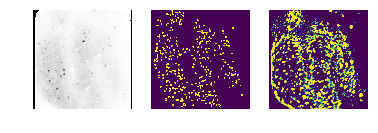

In [29]:
ax = plt.subplot(1,3,1);
plt.imshow(255*img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy()[0])

In [49]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [50]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(output, Variable(labels)).data.numpy()[0]

    print(loss)
    total += labels.size(0)
    correct += loss

print('Mean Loss: %.2f %%' % (
    correct / total))

81.0965
97.4433
Mean Loss: 89.27 %


In [30]:
predict = prediction.squeeze(0).squeeze(0).data.numpy()

In [31]:
from skimage.io import imsave

In [32]:
imsave(join(base, 'predict_0000.tif'), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')

In [59]:
predict.shape

(512, 512)